## Transformer Notebook

Example of distilbert model

In [1]:
from transformers import pipeline
import torch

classifier = pipeline(
    task="text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    torch_dtype=torch.float16,
    device=-1
)

result = classifier("Oh my god this guy is not good man...")
print(result)

c:\Dave\Apps\miniconda3.9\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


[{'label': 'NEGATIVE', 'score': 0.999779999256134}]


Setup GPU

In [1]:
import torch
print(torch.__version__)            # should say 2.5.1
print(torch.cuda.is_available())    # True
print(torch.cuda.get_device_name(0))  # GPU name

2.5.1
True
NVIDIA GeForce RTX 3060 Laptop GPU


Import our data and produce dataframes

In [2]:
import pandas as pd

df_train = pd.read_csv('./NLP_exam_emotions_dataset/train.txt', sep=';', header=None,)
df_train.columns = ["sentence", "emotion"]

df_test = pd.read_csv('./NLP_exam_emotions_dataset/test.txt', sep=';', header=None,)
df_test.columns = ["sentence", "emotion"]

df_val = pd.read_csv('./NLP_exam_emotions_dataset/validation.txt', sep=';', header=None,)
df_val.columns = ["sentence", "emotion"]

print("Training dataset shape: ", df_train.shape)
print("Test dataset shape: ", df_test.shape)
print("Validating dataset shape: ", df_val.shape)
df_train.head()


Training dataset shape:  (16000, 2)
Test dataset shape:  (2000, 2)
Validating dataset shape:  (2000, 2)


,sentence,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


Observe labels

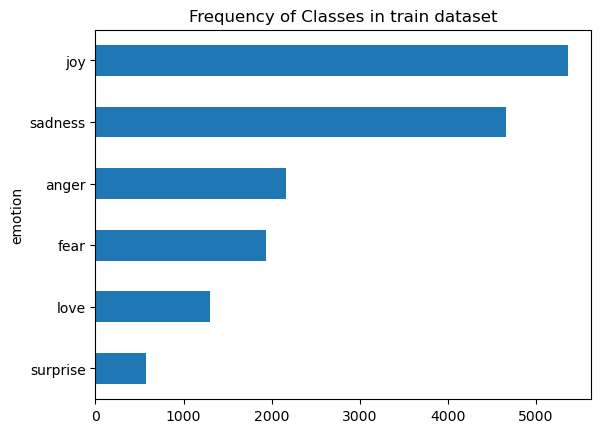

In [3]:
import matplotlib.pyplot as plt

label_counts = df_train['emotion'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Frequency of Classes in train dataset')
plt.show()

Change label text to a number, as required by distilbert

In [4]:
# Need to put labels as numbers for the model
label2id = {label: idx for idx, label in enumerate(label_counts.index)}
df_train['labels'] = df_train['emotion'].map(label2id)
df_test['labels'] = df_test['emotion'].map(label2id)
df_val['labels'] = df_val['emotion'].map(label2id)

Go from Pandas to Dataset (Huggingface)

In [5]:
from transformers import AutoTokenizer, DistilBertTokenizer, DistilBertModel
from datasets import load_dataset, Dataset, DatasetDict

ds = DatasetDict()
train_ds = Dataset.from_pandas(df_train)
ds['train'] = train_ds
test_ds = Dataset.from_pandas(df_test)
ds['test'] = test_ds
val_ds = Dataset.from_pandas(df_val)
ds['validation'] = val_ds
print(ds)

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = "NLP is awesome !"
encoded_text = tokenizer(text)
print(encoded_text)

def tokenize(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True) | {"labels": examples["labels"]}

tokenized_dataset = ds.map(tokenize, batched=True)
print(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'emotion', 'labels'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['sentence', 'emotion', 'labels'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['sentence', 'emotion', 'labels'],
        num_rows: 2000
    })
})
{'input_ids': [101, 17953, 2361, 2003, 12476, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


c:\Dave\Apps\miniconda3.9\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'emotion', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['sentence', 'emotion', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['sentence', 'emotion', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})


Training

In [6]:
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score


num_labels = len(label_counts)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is : ", device)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

batch_size = 16

training_args = TrainingArguments(output_dir = model_ckpt,
                                 num_train_epochs=2,
                                 learning_rate = 2e-5,
                                 fp16=True,
                                 per_device_train_batch_size= batch_size,
                                 per_device_eval_batch_size = batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm=False)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset=tokenized_dataset['validation'],
                  tokenizer=tokenizer)
trainer.train()


Device is :  cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Dave\Apps\miniconda3.9\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/2000 [00:00<?, ?it/s]

{'loss': 0.7508, 'grad_norm': 17.265317916870117, 'learning_rate': 1.5020000000000002e-05, 'epoch': 0.5}
{'loss': 0.2595, 'grad_norm': 19.08152198791504, 'learning_rate': 1.003e-05, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.19487255811691284, 'eval_accuracy': 0.9285, 'eval_f1': 0.9292739505937004, 'eval_runtime': 15.7138, 'eval_samples_per_second': 127.277, 'eval_steps_per_second': 7.955, 'epoch': 1.0}
{'loss': 0.1543, 'grad_norm': 1.3053419589996338, 'learning_rate': 5.03e-06, 'epoch': 1.5}
{'loss': 0.1515, 'grad_norm': 20.78704071044922, 'learning_rate': 3.0000000000000004e-08, 'epoch': 2.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 0.15834705531597137, 'eval_accuracy': 0.938, 'eval_f1': 0.9380726347510024, 'eval_runtime': 14.5946, 'eval_samples_per_second': 137.037, 'eval_steps_per_second': 8.565, 'epoch': 2.0}
{'train_runtime': 848.8037, 'train_samples_per_second': 37.7, 'train_steps_per_second': 2.356, 'train_loss': 0.3290307312011719, 'epoch': 2.0}


TrainOutput(global_step=2000, training_loss=0.3290307312011719, metrics={'train_runtime': 848.8037, 'train_samples_per_second': 37.7, 'train_steps_per_second': 2.356, 'total_flos': 4239259140096000.0, 'train_loss': 0.3290307312011719, 'epoch': 2.0})

Test set

In [8]:
preds_outputs = trainer.predict(tokenized_dataset['test'])
preds_outputs.metrics

  0%|          | 0/125 [00:00<?, ?it/s]

{'test_loss': 0.183211550116539,
 'test_accuracy': 0.9235,
 'test_f1': 0.9239185549409004,
 'test_runtime': 13.2477,
 'test_samples_per_second': 150.97,
 'test_steps_per_second': 9.436}

Metrics 

In [10]:
from sklearn.metrics import classification_report
import numpy as np

id2label = {idx: label for label, idx in label2id.items()}
y_preds = np.argmax(preds_outputs.predictions, axis=1)
y_true = tokenized_dataset['test'][:]['labels']
print(classification_report(y_true, y_preds, target_names=[id2label[i] for i in sorted(id2label.keys())]))

              precision    recall  f1-score   support

    surprise       0.73      0.70      0.71        66
        love       0.79      0.91      0.84       159
        fear       0.89      0.87      0.88       224
       anger       0.91      0.94      0.92       275
     sadness       0.97      0.96      0.96       581
         joy       0.96      0.93      0.94       695

    accuracy                           0.92      2000
   macro avg       0.87      0.88      0.88      2000
weighted avg       0.93      0.92      0.92      2000

